# Init

In [0]:
import astropy
import astropy.units as u
import astropy.constants as C 

import numpy as np
import matplotlib.pyplot as plt

import mpmath
import scipy.integrate
from astropy.cosmology import Planck15 as cosmo

# Numerical values for equations

2.591815677359873e-13


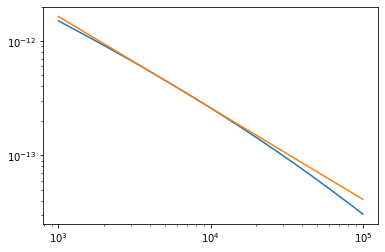

In [3]:

def alpha_rec_B(T):
    """Recombination rate for `case B` recombination.

    Fitting formulae from Hui & Gnedin (1997) (in the Appendix)
    accurate to ~2% from 3 - 10^9K

    Returns recombination rate in cm**3/s
    """
    lHI = 2 * 157807.0 / T
    alpha_B = 2.753e-14 * lHI**1.5 / (1.0 + (lHI / 2.740)**0.407)**2.242

    return alpha_B    

T = np.logspace(3, 5)
print(alpha_rec_B(1e4))
plt.loglog(T, alpha_rec_B(T))
plt.loglog(T, 2.6e-13 * (T/1e4)**-0.8)

In [0]:
H0 = 68. * u.km/(u.s * u.Mpc)
Om = 0.31
OL = 0.69

def H(z):
  return H0 * (Om * (z+1)**3 + OL)**(0.5)

In [0]:
## What is A?
falpha = 0.416
lambda_alpha = 1215.67 * u.Angstrom
A = falpha * np.pi * C.e.gauss**2 * lambda_alpha / (C.m_e * C.c)
print(A.to('cm**3/s'))

1.3421819608040695e-07 cm3 / s


In [0]:
## Eq 7 --> Nion
# MUV = -18
# beta = -2
# alpha = -1.5
MUV = -20
beta = -2
alpha = -2
z = 7.
Nion = 6.6e46 * (10**(-0.4 * MUV)/ (alpha * (1 + z)**(beta + 1))) * ( 912/1500 )**(beta+2)
print(Nion)

print("%e" %((1+z) * 6.6e46 * 10**(-0.4 * MUV)/np.abs(alpha)))

-2.64e+55
2.640000e+55


In [0]:
## For equation (11) --> R_alpha
z = 7.
A = 1.342182e-7 * u.cm**3 / u.s
fesc = 0.2
Nion = 5e54 / u.s #6.6e46 * u.s**(-1)
sigma_ion = 6.3e-18 * u.cm**2
alpha = -1.5 # ???
Js = fesc * Nion * sigma_ion * alpha / (alpha - 3)
tau_lim = 2.3
C_H = 3
n_H = 1.88e-7 * (1+z)**3 * u.cm**(-3)
alpha_B = alpha_rec_B(1e4) * u.cm**3 / u.s
print(alpha_B)
print(Nion * fesc)
print("n_H", n_H)

print((Js**0.5 * (A * C_H**2 * n_H**2 * alpha_B / (H(z) * tau_lim))**(-0.5)).to('Mpc'))

2.591815677359873e-13 cm3 / s
1e+54 1 / s
n_H 9.6256e-05 1 / cm3
0.0697548273355714 Mpc


In [0]:
## R_alpha (Charlotte)
z_fid        = 7
fesc_fid     = 1
Ndot_ion_fid = 1e55/u.s
alpha_fid    = -2
tau_lim_fid  = 2.3
C_H_fid      = 3
T_fid        = 1e4*u.K

def R_alpha(z=z_fid, 
            Ndot_ion=Ndot_ion_fid, fesc=fesc_fid, alpha=alpha_fid, 
            tau_lim=tau_lim_fid, C_H=C_H_fid, T=T_fid):
    """
    Radius R<R_alpha optically thin to Lya
    """

    sigma_ion0 = 6.3e-18 * u.cm**2
    sigma_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5 * u.cm**2.
    v_therm    = (1./np.sqrt(C.m_p/2./C.k_B/T)).to(u.km/u.s)
    
    prefactor = (sigma_ion0/4./np.pi**1.5/v_therm/sigma_Lya0)
    
    nH0 = 1.88e-7 * u.cm**(-3)
    nH  = nH0 * (1+z)**3
    
    Hz0 = np.sqrt(Om) * H0
    Hz  = Hz0 * (1+z)**1.5

 #     alpha_rec = bubbles.alpha_rec_B(T.value)
    alpha_rec = 2.6e-13*u.cm**3./u.s * (T.value/1e4)**-0.8 
      
    R2 = prefactor * fesc * Ndot_ion * (alpha/(alpha-3)) * tau_lim \
            / alpha_rec / C_H**2. \
            * (Hz0/nH0**2.)*(1+z)**-4.5
    
    return np.sqrt(R2).to(u.Mpc)

print(R_alpha(z=7, T=1e4*u.K))

0.06794659882757244 Mpc


# How many blue peaks can we find within a bubble?

## Luminosity function

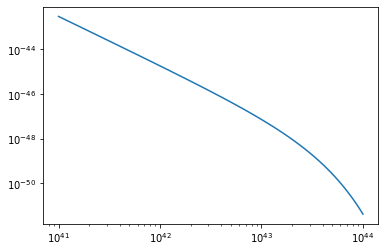

In [11]:
# LF data from my paper
dat =  np.array([[ 1.9       ,  0.51420951, -1.80785399,  1.38076063],
       [ 2.1       ,  0.59001568, -1.84109248,  1.09261539],
       [ 2.3       ,  0.67091729, -1.87013566,  0.87591547],
       [ 2.5       ,  0.75504085, -1.89516034,  0.71322654],
       [ 2.7       ,  0.84024555, -1.91653433,  0.59070911],
       [ 2.9       ,  0.92448248, -1.93479566,  0.49762327],
       [ 3.1       ,  1.00610828, -1.95058048,  0.42585582],
       [ 3.3       ,  1.08403481, -1.96453025,  0.36945116],
       [ 3.5       ,  1.15770048, -1.97721561,  0.3241514 ],
       [ 3.7       ,  1.22693822, -1.98909689,  0.28697123],
       [ 3.9       ,  1.29182788, -2.00051953,  0.25583709],
       [ 4.1       ,  1.35258063, -2.01172966,  0.22930723],
       [ 4.3       ,  1.40946481, -2.02289637,  0.20636913],
       [ 4.5       ,  1.46276342, -2.03413238,  0.18630019],
       [ 4.7       ,  1.51275218, -2.04551083,  0.16857448],
       [ 4.9       ,  1.55968929, -2.05707743,  0.15280069],
       [ 5.1       ,  1.60381149, -2.06885915,  0.1386811 ],
       [ 5.3       ,  1.64533353, -2.0808703 ,  0.12598407],
       [ 5.5       ,  1.68444913, -2.09311672,  0.11452545],
       [ 5.7       ,  1.72133263, -2.10559864,  0.10415585],
       [ 5.9       ,  1.75614057, -2.11831233,  0.09475194],
       [ 6.1       ,  1.7890139 , -2.13125188,  0.08621004],
       [ 6.3       ,  1.82007998, -2.14440995,  0.0784417 ],
       [ 6.5       ,  1.84945323, -2.15777821,  0.07137062],
       [ 6.7       ,  1.87723765, -2.17134797,  0.0649301 ],
       [ 6.9       ,  1.90352728, -2.18511051,  0.05906137],
       [ 7.1       ,  1.92840751, -2.19905705,  0.05371225],
       [ 7.3       ,  1.9519563 , -2.21317909,  0.04883603],
       [ 7.5       ,  1.97424485, -2.2274685 ,  0.04439075],
       [ 7.7       ,  1.9953371 , -2.24191714,  0.04033858],
       [ 7.9       ,  2.01529321, -2.25651759,  0.03664517]])

def luminosity_function(z, L):
  """Returns number density in cMpc^-3"""
  Ls = np.interp(z, dat[:,0], dat[:,1]) * 1e43   # in 1e43 erg/s
  alpha = np.interp(z, dat[:,0], dat[:,2])
  phi = np.interp(z, dat[:,0], dat[:,3])   # in 1e-3 cMpc^-3

  Lrat = L / Ls
  return 1e-3 * phi * (Lrat)**alpha * np.exp(-Lrat) / Ls # per dL (not d(L/Ls) as common)


x = np.logspace(41,44,100)
y = luminosity_function(7.,x)
plt.loglog(x,y)

In [12]:
def _int_lf(z,Lmin,Lmax = 1e45):
  """Integrate LF between Lmin and Lmax"""
  fun = lambda x : luminosity_function(z,x)
  y, other = scipy.integrate.quad(fun,Lmin,Lmax)
  return y

def number_lae(z, Ralpha, Llim):
  """Returns number of LAEs within < Ralpha (in pMpc) and > Llim (in erg/s)"""
  V = 4/3. * np.pi * Ralpha**3 # bubble volume
  N = _int_lf(z,  Llim) * (1+z)**3 # in pMpc**(-3)
  return N * V

print(number_lae(7.,0.2,1e40))

6.623873394532385


### Integration test

In [13]:
fun = lambda x : luminosity_function(7.,x)
print("%e" %(_int_lf(7.,1e40,1e46)))
scipy.integrate.quad(fun,1e40,1e45, full_output=True)

3.339473e-01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  after removing the cwd from sys.path.


(0.3860676976884965,
 1.9789224238998907e-09,
 {'alist': array([1.00000000e+40, 5.00005000e+44, 2.50007500e+44, 1.25008750e+44,
         6.25093750e+43, 3.12596875e+43, 1.56348437e+43, 7.82242188e+42,
         3.91621094e+42, 1.96310547e+42, 9.86552734e+41, 4.98276367e+41,
         2.54138184e+41, 1.32069092e+41, 7.10345459e+40, 4.05172729e+40,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00]),
  'blist': array([4.051727

## Try to compute fluxes

In [0]:
def v_to_lambda(v, z, lambda0 = 1215.67 * u.Angstrom):
    return (v / C.c + 1.) * lambda0 * (z + 1)


In [16]:
z = 7.
L = 1e40 * u.erg / u.second # use Lmin from above
d_L = cosmo.luminosity_distance(z)
Fblue = 0.5 # flux on blue side...

print((Fblue * L / (4 * np.pi * d_L**2)).to('erg/(s * cm**2)'))

8.388722155979206e-21 erg / (cm2 s)


## JWST depth



In [28]:
# S/N ~ 10, 2.8hr exposure: 2e-18 erg/s/cm^2

sigma_5_3hr = 1e-18 * u.erg/u.s/u.cm**2.
def JWST_depth(t_hrs, StoN=5):
  return StoN/5 * sigma_5_3hr * np.sqrt(2.8/t_hrs)
print('5hr JWST depth: {0:.1e}'.format(JWST_depth(t_hrs=5, StoN=5)))

depth_needed = 1e-20 * u.erg/u.s/u.cm**2.
sqrt_t = sigma_5/depth_needed

t_ratio = sqrt_t **2.
print('{0:.0f} hrs to see {1:.0e}'.format(t_ratio * 2.8, depth_needed))

5hr JWST depth: 7.5e-19 erg / (cm2 s)
28000 hrs to see 1e-20 erg / (cm2 s)


## Check LF calculation 

Compare with Schechter LF number counts + Drake+17 MUSE Lya LF

Not sure if Drake+17 is phistar is for logL or not, anyway, Max's integral worked :)


In [0]:
z      = 6.9
Ls     = 1.90352728*1e43
logLs  = np.log10(Ls)
alpha  = -2.18511051
phi    = 0.05906137e-3
logphi = np.log10(phi)

def _int_lf_Schechter(logLmin = 40, 
                      logPhistar=logphi, alpha=alpha, logLstar=logLs):
  """Integrate Schechter LF from Lmin to infinity
  Params from Max's model z~6.9
  Lstar in erg/s
  Phistar in cMpc^-3
  """
  Phistar   = 10**logPhistar # cMpc^3
  LminLstar = 10**(logLmin - logLstar)
  return Phistar*mpmath.gammainc(alpha + 1., LminLstar)

In [30]:
## Check Max's LF integral
logLmin = 41

print(_int_lf_Schechter(logLmin=logLmin))
print(_int_lf(z=6.9, Lmin=10**logLmin))

0.0245308829375767
0.024530882937576774


## Cumulative number in a bubble, changing alpha

In [20]:
def number_lae_alpha(z, Ralpha, logLmin, alpha=-2.18511051):
  """Returns number of LAEs within < Ralpha (in pMpc) and > Llim (in erg/s)"""
  V = 4/3. * np.pi * Ralpha**3 # bubble volume
  N = _int_lf_Schechter(logLmin=logLmin, alpha=alpha) * (1+z)**3 # in pMpc**(-3)
  return N * V
  
print(number_lae_alpha(z=6.9, Ralpha=0.2, logLmin=40))
print(number_lae(7.,0.2,1e40))

6.32604034584969
6.623873394532385


Check cumulative number > Flux limit

Text(0, 0.5, '$N(>F_{\\rm blue})$ in 0.3 pMpc proximity zone')

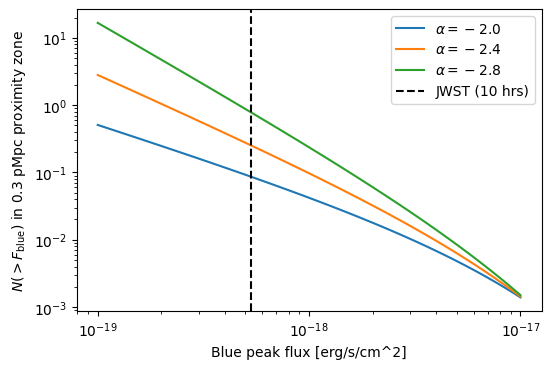

In [34]:
F_tab = np.logspace(-19, -17) * u.erg/u.cm**2./u.s
L_tab = (4*np.pi*d_L**2. * F_tab/Fblue).to(u.erg/u.s)

plt.figure(figsize=(6,4), dpi=100)
Ralpha = 0.3
for alpha in [-2., -2.4, -2.8]:
  N_LAE = [number_lae_alpha(6.9, Ralpha, np.log10(L.value), alpha=alpha) for L in L_tab]
  plt.loglog(F_tab, N_LAE, label=r'$\alpha = %.1f$' % alpha)

plt.axvline(JWST_depth(t_hrs=10, StoN=5).value, c='k', ls='dashed', label='JWST (10 hrs)')

plt.legend()
plt.xlabel('Blue peak flux [erg/s/cm^2]')
plt.ylabel(r'$N(>F_{\rm blue})$ in %.1f pMpc proximity zone' % Ralpha)